# StyleGAN2 + CLIP Finetuning (StyleGAN-NADA)

**What we do:** Finetune StyleGAN2 (faces) with CLIP so that generated images move toward a target text domain ("a drawn anime style face") while keeping the source domain ("a photo of a face"). Uses *directional* CLIP loss: align image direction ΔI with text direction ΔT.

**Steps:**
- **1** — Mount Drive, create folders (models, checkpoints, output)
- **2** — Install pip deps (ftfy, regex, tqdm, gdown, Ninja)
- **3** — Clone StyleGAN2 + CLIP repos to Drive, download weights
- **4** — Load StyleGAN2 generator (FFHQ)
- **5** — Load CLIP (ViT-B/32)
- **6** — Sanity check: generate face, CLIP similarity
- **7** — Split into G_frozen (no grad) and G_train (synthesis trainable)
- **8** — Define source/target text prompts, directional CLIP loss
- **9** — Training loop, save checkpoints to Drive
- **10** — Generate samples with trained G_train

## Step 1: Storage and folder structure

Choose where to store models, checkpoints, and output:

- **Google Drive** — set `USE_GOOGLE_DRIVE = True`. Drive will be mounted; all data persists across Colab sessions.
- **Local (content folder)** — set `USE_GOOGLE_DRIVE = False`. Uses `/content/StyleGAN_NADA` with the same folder structure (models, repos, checkpoints, output). Data is lost when the session ends.

In [1]:
# Set to True to use Google Drive; False to use local /content/StyleGAN_NADA (same folder structure)
USE_GOOGLE_DRIVE = False

In [ ]:
import os

if USE_GOOGLE_DRIVE:
    from google.colab import drive
    drive.mount("/content/drive")
    PROJECT_BASE = "/content/drive/MyDrive/StyleGAN_NADA"
    storage_label = "Google Drive"
else:
    PROJECT_BASE = "/content/StyleGAN_NADA"
    storage_label = "local (content)"

MODELS_DIR = os.path.join(PROJECT_BASE, "models")
REPOS_DIR = os.path.join(PROJECT_BASE, "repos")
CHECKPOINTS_DIR = os.path.join(PROJECT_BASE, "checkpoints/2")
OUTPUT_DIR = os.path.join(PROJECT_BASE, "output")

for d in [MODELS_DIR, REPOS_DIR, CHECKPOINTS_DIR, OUTPUT_DIR]:
    os.makedirs(d, exist_ok=True)

print(f"Storage: {storage_label}")
print("  models:", MODELS_DIR)
print("  repos:", REPOS_DIR)
print("  checkpoints:", CHECKPOINTS_DIR)
print("  output:", OUTPUT_DIR)

Storage: local (content)
  models: /content/StyleGAN_NADA/models
  repos: /content/StyleGAN_NADA/repos
  checkpoints: /content/StyleGAN_NADA/checkpoints/v2
  output: /content/StyleGAN_NADA/output


## Step 2: Install dependencies and imports

Install only pip deps (ftfy, regex, tqdm, gdown, Ninja). CLIP code is taken from the repo on Drive (Step 3), not from pip.

In [3]:
# Dependencies (Colab already has torch, torchvision). CLIP repo is on Drive (Step 3).
!pip install -q ftfy regex tqdm gdown Ninja

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 14.9 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import sys
import random
import numpy as np
from pathlib import Path

print(f"CUDA: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'none'}")

CUDA: True
GPU: Tesla T4


In [5]:
# Fix random seeds so everyone gets the same results (like in StyleGAN_HW)
SEED = 3456
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
print(f"Seeds fixed to {SEED} for reproducibility.")

Seeds fixed to 3456 for reproducibility.


## Step 3: Repos and weights on Drive (all in one place)

Clone repos to Drive only if not already present, then download weights. We work from disk so we don't re-download each session.
- **StyleGAN2**: repo `repos/stylegan2-pytorch`, weights in `models/`
- **CLIP**: repo `repos/CLIP`, weights in `models/clip_cache/`

In [6]:
# Repos on Drive: clone only if not present
STYLEGAN2_ROOT = os.path.join(REPOS_DIR, "stylegan2-pytorch")
if not os.path.isfile(os.path.join(STYLEGAN2_ROOT, "model.py")):
    print("StyleGAN2 repo not on disk, cloning...")
    !git clone https://github.com/rosinality/stylegan2-pytorch.git "{STYLEGAN2_ROOT}"
    print("StyleGAN2 done.")
else:
    print("StyleGAN2 repo already on disk at", STYLEGAN2_ROOT)

CLIP_ROOT = os.path.join(REPOS_DIR, "CLIP")
if not os.path.isfile(os.path.join(CLIP_ROOT, "clip", "model.py")):
    print("CLIP repo not on disk, cloning...")
    !git clone https://github.com/openai/CLIP.git "{CLIP_ROOT}"
    print("CLIP done.")
else:
    print("CLIP repo already on disk at", CLIP_ROOT)

sys.path.insert(0, STYLEGAN2_ROOT)
sys.path.insert(0, CLIP_ROOT)

StyleGAN2 repo not on disk, cloning...
Cloning into '/content/StyleGAN_NADA/repos/stylegan2-pytorch'...
remote: Enumerating objects: 395, done.
remote: Total 395 (delta 0), reused 0 (delta 0), pack-reused 395 (from 1)
Receiving objects: 100% (395/395), 122.51 MiB | 43.65 MiB/s, done.
Resolving deltas: 100% (205/205), done.
StyleGAN2 done.
CLIP repo not on disk, cloning...
Cloning into '/content/StyleGAN_NADA/repos/CLIP'...
remote: Enumerating objects: 256, done.
remote: Total 256 (delta 0), reused 0 (delta 0), pack-reused 256 (from 1)
Receiving objects: 100% (256/256), 8.87 MiB | 28.30 MiB/s, done.
Resolving deltas: 100% (136/136), done.
CLIP done.


In [7]:
import gdown

# Download weights only if not already on disk (avoid re-downloading from external sources)
FILES = {
    "stylegan2-ffhq-config-f.pt": "1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT",
}

for name, file_id in FILES.items():
    path = os.path.join(MODELS_DIR, name)
    if os.path.isfile(path):
        print(f"Already on disk, skip: {name}")
        continue
    print(f"Downloading {name}...")
    gdown.download(
        f"https://drive.google.com/uc?id={file_id}",
        path,
        quiet=False,
    )

# CLIP: download to Drive if not cached yet (same as other models)
import clip
CLIP_CACHE = os.path.join(MODELS_DIR, "clip_cache")
os.makedirs(CLIP_CACHE, exist_ok=True)
_device = "cuda" if torch.cuda.is_available() else "cpu"
clip.load("ViT-B/32", device=_device, download_root=CLIP_CACHE)
print("CLIP weights cached in:", CLIP_CACHE)
print("Weights path:", MODELS_DIR)

Downloading...
From (original): https://drive.google.com/uc?id=1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT
From (redirected): https://drive.google.com/uc?id=1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT&confirm=t&uuid=87d99f9b-c814-47af-b8ed-f033d6c84dbb
To: /content/StyleGAN_NADA/models/stylegan2-ffhq-config-f.pt
100%|██████████| 381M/381M [00:02<00:00, 128MB/s]  
100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 105MiB/s]


CLIP weights cached in: /content/StyleGAN_NADA/models/clip_cache
Weights path: /content/StyleGAN_NADA/models


## Step 4: Load StyleGAN2 generator

Load the StyleGAN2 Generator from the repo on Drive and load pretrained FFHQ weights from Drive.

In [8]:
from model import Generator

device = "cuda" if torch.cuda.is_available() else "cpu"
latent_dim = 512
generator = Generator(size=1024, style_dim=latent_dim, n_mlp=8).to(device)

ckpt_path = os.path.join(MODELS_DIR, "stylegan2-ffhq-config-f.pt")
ckpt = torch.load(ckpt_path, map_location=device)
generator.load_state_dict(ckpt["g_ema"])
generator.eval()

print("StyleGAN2 generator loaded from", ckpt_path)

StyleGAN2 generator loaded from /content/StyleGAN_NADA/models/stylegan2-ffhq-config-f.pt


## Step 5: Load CLIP

Load CLIP (ViT-B/32) from cache (downloaded in Step 3).

In [9]:
import clip

CLIP_CACHE = os.path.join(MODELS_DIR, "clip_cache")
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device, download_root=CLIP_CACHE)
clip_model.eval()

# Quick check: encode a text
with torch.no_grad():
    t = clip.tokenize(["a photo of a face"]).to(device)
    E = clip_model.encode_text(t)
print("CLIP loaded. Text embedding shape:", E.shape)

CLIP loaded. Text embedding shape: torch.Size([1, 512])


## Step 6: Sanity check — generate image, CLIP

Generate one face with StyleGAN2, display it, and compare the image with the text "a photo of a face" via CLIP (cosine similarity).

/content/StyleGAN_NADA/repos/stylegan2-pytorch/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 2.9.0+cu126. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


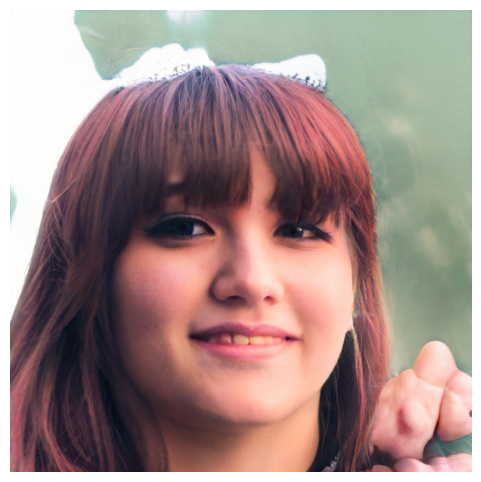

StyleGAN2 output shape: torch.Size([1, 3, 1024, 1024])
CLIP similarity (image vs 'a photo of a face'): 0.2520
(1.0 = perfect match; typical face photo is ~0.25–0.35)


In [10]:
import matplotlib.pyplot as plt

# 1. Generate one face
z = torch.randn(1, latent_dim, device=device)
with torch.no_grad():
    img, _ = generator([z], input_is_latent=False)
# img: (1, 3, 1024, 1024), range [-1, 1]

# 2. Display
def show_img(tensor):
    x = (tensor.clamp(-1, 1) + 1) / 2
    x = x.squeeze(0).permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(6, 6))
    plt.imshow(x)
    plt.axis("off")
    plt.show()

show_img(img)
print("StyleGAN2 output shape:", img.shape)

# 3. CLIP: compare image with text "a photo of a face" (use official clip_preprocess)

# Tensor-only preprocess: mean/std from CLIP's native preprocess, preserves gradients
from torchvision.transforms import Normalize
for _t in clip_preprocess.transforms:
    if isinstance(_t, Normalize):
        _clip_mean, _clip_std = _t.mean, _t.std
        break
else:
    raise RuntimeError("CLIP preprocess has no Normalize layer")

def preprocess_for_clip(images):
    """images: (B, 3, H, W) in [-1, 1]. Same as CLIP preprocess, tensor-only (gradients flow)."""
    images = torch.nn.functional.interpolate(images, size=(224, 224), mode="bilinear")
    images = (images.clamp(-1, 1) + 1) / 2
    mean = torch.tensor(_clip_mean, device=images.device).view(1, 3, 1, 1)
    std = torch.tensor(_clip_std, device=images.device).view(1, 3, 1, 1)
    return (images - mean) / std

text_prompt = "a photo of a face"
with torch.no_grad():
    img_clip = preprocess_for_clip(img)
    img_enc = clip_model.encode_image(img_clip)
    text_enc = clip_model.encode_text(clip.tokenize([text_prompt]).to(device))
    img_enc = img_enc / img_enc.norm(dim=-1, keepdim=True)
    text_enc = text_enc / text_enc.norm(dim=-1, keepdim=True)
    similarity = (img_enc * text_enc).sum(dim=-1).item()

print(f"CLIP similarity (image vs '{text_prompt}'): {similarity:.4f}")
print("(1.0 = perfect match; typical face photo is ~0.25–0.35)")

## Step 7: G_frozen and G_train

Two generators: G_frozen (no gradients) and G_train (only synthesis is trainable; mapping is frozen so both get the same w from z).

In [11]:
# List all generator layer names (to see what to freeze in G_train)
for name, _ in generator.named_parameters():
    print(name)

style.1.weight
style.1.bias
style.2.weight
style.2.bias
style.3.weight
style.3.bias
style.4.weight
style.4.bias
style.5.weight
style.5.bias
style.6.weight
style.6.bias
style.7.weight
style.7.bias
style.8.weight
style.8.bias
input.input
conv1.conv.weight
conv1.conv.modulation.weight
conv1.conv.modulation.bias
conv1.noise.weight
conv1.activate.bias
to_rgb1.bias
to_rgb1.conv.weight
to_rgb1.conv.modulation.weight
to_rgb1.conv.modulation.bias
convs.0.conv.weight
convs.0.conv.modulation.weight
convs.0.conv.modulation.bias
convs.0.noise.weight
convs.0.activate.bias
convs.1.conv.weight
convs.1.conv.modulation.weight
convs.1.conv.modulation.bias
convs.1.noise.weight
convs.1.activate.bias
convs.2.conv.weight
convs.2.conv.modulation.weight
convs.2.conv.modulation.bias
convs.2.noise.weight
convs.2.activate.bias
convs.3.conv.weight
convs.3.conv.modulation.weight
convs.3.conv.modulation.bias
convs.3.noise.weight
convs.3.activate.bias
convs.4.conv.weight
convs.4.conv.modulation.weight
convs.4.conv.mo

In [27]:
import copy

G_frozen = copy.deepcopy(generator)
for p in G_frozen.parameters():
    p.requires_grad = False

G_train = copy.deepcopy(generator)

# Synthesis layers we can selectively unfreeze (per paper Sec 4.2):
# conv1 + convs.0..15 = 17 blocks. Always freeze: mapping (style), to_rgb1, to_rgbs.
SYNTHESIS_LAYER_NAMES = ["conv1"] + [f"convs.{i}" for i in range(16)]
N_SYNTHESIS_LAYERS = len(SYNTHESIS_LAYER_NAMES)  # 17

def _param_belongs_to_layer(name, layer_name):
    return name == layer_name or name.startswith(layer_name + ".")

def freeze_all_synthesis(G):
    """Freeze style (mapping), to_rgb1, to_rgbs, and all synthesis conv blocks."""
    for name, p in G.named_parameters():
        if "style" in name or "to_rgb" in name:
            p.requires_grad = False
        elif any(_param_belongs_to_layer(name, ln) for ln in SYNTHESIS_LAYER_NAMES):
            p.requires_grad = False
        else:
            p.requires_grad = False

def set_trainable_layers(G, layer_indices):
    """Unfreeze only the given synthesis layer indices (0..16). Freeze the rest."""
    freeze_all_synthesis(G)
    for idx in layer_indices:
        ln = SYNTHESIS_LAYER_NAMES[idx]
        for name, p in G.named_parameters():
            if _param_belongs_to_layer(name, ln):
                p.requires_grad = True

# Adaptive layer-freezing (paper Sec 4.2): k layers unfrozen per step.
K_LAYERS = 12  # 2/3 of 17 for texture/shape, 3 for animals (dog→cat etc.)

freeze_all_synthesis(G_train)

n_trainable = sum(p.numel() for p in G_train.parameters() if p.requires_grad)
print("G_frozen: all params frozen. G_train:", n_trainable, "trainable params (adaptive freezing, k =", K_LAYERS, ")")

G_frozen: all params frozen. G_train: 0 trainable params (adaptive freezing, k = 12 )


## Step 8: Text prompts and directional CLIP loss

**Идея:** Обучаем G_train так, чтобы *направление* изменения изображения (от «фото» к «аниме») совпадало с *направлением* в пространстве текстов CLIP.

**Формула (directional CLIP loss):**
- $\Delta T = E_T(\text{target}) - E_T(\text{source})$ — направление между целевым и исходным текстом в CLIP (разность эмбеддингов)
- $\Delta I = E_I(G_{\text{train}}(w)) - E_I(G_{\text{frozen}}(w))$ — направление между «обученным» и «замороженным» изображением (одно и то же w, разный генератор)
- $L = 1 - \cos(\Delta I, \Delta T) = 1 - \frac{\Delta I \cdot \Delta T}{\|\Delta I\| \cdot \|\Delta T\|}$

**Что это даёт:** Минимизируем L → cos(ΔI, ΔT) → 1 → ΔI выравнивается по ΔT. То есть изображение движется в сторону target-текста так же, как текст target отличается от source.

In [28]:
text_source = "a photo of a face"
text_target = "a drawn anime style face"

with torch.no_grad():
    t_s = clip.tokenize([text_source]).to(device)
    t_t = clip.tokenize([text_target]).to(device)
    E_t_source = clip_model.encode_text(t_s)
    E_t_target = clip_model.encode_text(t_t)


def directional_clip_loss(img_frozen, img_train, E_t_source, E_t_target, clip_model, preprocess_fn):
    img_f = preprocess_fn(img_frozen)
    img_t = preprocess_fn(img_train)
    E_i_frozen = clip_model.encode_image(img_f)
    E_i_train = clip_model.encode_image(img_t)
    delta_I = E_i_train - E_i_frozen
    delta_T = E_t_target - E_t_source
    delta_T = delta_T.expand(delta_I.shape[0], -1)
    delta_I_norm = delta_I / (delta_I.norm(dim=-1, keepdim=True) + 1e-8)
    delta_T_norm = delta_T / (delta_T.norm(dim=-1, keepdim=True) + 1e-8)
    cos_sim = (delta_I_norm * delta_T_norm).sum(dim=-1)
    return 1 - cos_sim.mean()


def global_clip_loss(img, E_t_target, clip_model, preprocess_fn):
    """Global CLIP loss: D_CLIP(G(w), t_target). Used for Phase 1 layer selection."""
    img_c = preprocess_fn(img)
    E_i = clip_model.encode_image(img_c)
    E_i_norm = E_i / (E_i.norm(dim=-1, keepdim=True) + 1e-8)
    E_t = E_t_target.expand(E_i.shape[0], -1)
    E_t_norm = E_t / (E_t.norm(dim=-1, keepdim=True) + 1e-8)
    cos_sim = (E_i_norm * E_t_norm).sum(dim=-1)
    return 1 - cos_sim.mean()


def select_layers_for_adaptive_freezing(G, clip_model, preprocess_fn, E_t_target, device,
                                        n_w=8, n_i=1, k=12, latent_dim=512):
    """
    Phase 1: Optimize w in W+ with global CLIP loss (G frozen), pick k layers with largest w change.
    Returns list of layer indices (0..16) to unfreeze.
    """
    n_latent = G.n_latent  # 18 for 1024
    # W+ indices that feed conv blocks: 0->conv1, 2,3->convs[0,1], 4,5->convs[2,3], ...
    w_idx_to_layer = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]  # 17 layers

    # Sample N_w latent codes
    z = torch.randn(n_w, latent_dim, device=device)
    with torch.no_grad():
        w_init = G.style(z)  # (n_w, 512)
        w_plus_init = w_init.unsqueeze(1).repeat(1, n_latent, 1)  # (n_w, n_latent, 512)
    w_plus = w_plus_init.clone().detach().requires_grad_(True)
    opt_w = torch.optim.Adam([w_plus], lr=0.1)

    G.eval()
    for _ in range(n_i):
        opt_w.zero_grad()
        img, _ = G([w_plus], input_is_latent=True)
        loss = global_clip_loss(img, E_t_target, clip_model, preprocess_fn)
        loss.backward()
        opt_w.step()

    with torch.no_grad():
        delta_w = (w_plus - w_plus_init).abs().sum(dim=(0, 2))  # (n_latent,) - change per w slot
    # Map to layer change (use first 17 w slots for 17 layers)
    layer_changes = delta_w[:17].cpu().numpy()
    top_k_idx = np.argsort(layer_changes)[::-1][:k]
    return list(top_k_idx)


print("Text prompts encoded. directional_clip_loss and global_clip_loss ready.")

Text prompts encoded. directional_clip_loss and global_clip_loss ready.


## Step 9: Training loop

**Adaptive layer-freezing** (paper Sec 4.2): each iteration, Phase 1 selects k layers via latent optimization (global CLIP loss), Phase 2 trains only those layers with directional loss.

In [29]:
from torch.optim import AdamW
from tqdm import tqdm

n_iter = 500
batch_size = 2
log_every = 50
lr = 0.002

# Adaptive layer-freezing params (paper Appendix I)
N_W = 3   # latent codes for layer selection
N_I = 1   # iterations of w optimization in Phase 1

# Optimizer is created inside the loop after set_trainable_layers (G_train starts fully frozen)

for i in tqdm(range(n_iter)):
    # Phase 1: Freeze G_train (optimize w only), then select k layers
    freeze_all_synthesis(G_train)
    selected = select_layers_for_adaptive_freezing(
        G_train, clip_model, preprocess_for_clip, E_t_target, device,
        n_w=N_W, n_i=N_I, k=K_LAYERS, latent_dim=latent_dim,
    )
    set_trainable_layers(G_train, selected)
    optimizer = AdamW(
        filter(lambda p: p.requires_grad, G_train.parameters()),
        lr=lr,
    )

    # Phase 2: Train with directional CLIP loss
    z = torch.randn(batch_size, latent_dim, device=device)
    with torch.no_grad():
        w = G_frozen.style(z)
    img_frozen, _ = G_frozen([w], input_is_latent=True)
    img_train, _ = G_train([w], input_is_latent=True)
    loss = directional_clip_loss(
        img_frozen.detach(), img_train,
        E_t_source, E_t_target,
        clip_model, preprocess_for_clip,
    )
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i + 1) % log_every == 0:
        n_tr = sum(p.numel() for p in G_train.parameters() if p.requires_grad)
        print(f"Iter {i+1}, loss: {loss.item():.4f}, trainable params: {n_tr}")
        epoch = i + 1
        epoch_dir = os.path.join(CHECKPOINTS_DIR, str(epoch))
        os.makedirs(epoch_dir, exist_ok=True)
        torch.save({
            "G_train": G_train.state_dict(),
            "iter": epoch,
            "source": text_source,
            "target": text_target,
        }, os.path.join(epoch_dir, f"checkpoint_{epoch}.pt"))

print("Training done. Checkpoints in", CHECKPOINTS_DIR)

 10%|▉         | 49/500 [00:49<07:40,  1.02s/it]

Iter 50, loss: 0.7275, trainable params: 25979404


 20%|█▉        | 99/500 [01:39<06:36,  1.01it/s]

Iter 100, loss: 0.8120, trainable params: 23496396


 30%|██▉       | 149/500 [02:29<05:52,  1.00s/it]

Iter 150, loss: 0.7432, trainable params: 25905612


 40%|███▉      | 199/500 [03:19<05:04,  1.01s/it]

Iter 200, loss: 0.6963, trainable params: 25979404


 50%|████▉     | 249/500 [04:10<04:12,  1.01s/it]

Iter 250, loss: 0.6890, trainable params: 25327756


 60%|█████▉    | 299/500 [05:00<03:20,  1.00it/s]

Iter 300, loss: 0.7129, trainable params: 25979404


 70%|██████▉   | 349/500 [05:50<02:31,  1.00s/it]

Iter 350, loss: 0.6958, trainable params: 23496396


 80%|███████▉  | 399/500 [06:41<01:43,  1.02s/it]

Iter 400, loss: 0.6895, trainable params: 24606604


 90%|████████▉ | 449/500 [07:31<00:51,  1.00s/it]

Iter 450, loss: 0.6953, trainable params: 25397452


100%|█████████▉| 499/500 [08:21<00:01,  1.00s/it]

Iter 500, loss: 0.6919, trainable params: 25327756


100%|██████████| 500/500 [08:23<00:00,  1.01s/it]

Training done. Checkpoints in /content/StyleGAN_NADA/checkpoints/v2


## Step 10: Generate with trained model

Sample images with the same z as before (or new z) using G_train to see the sketch-like result.

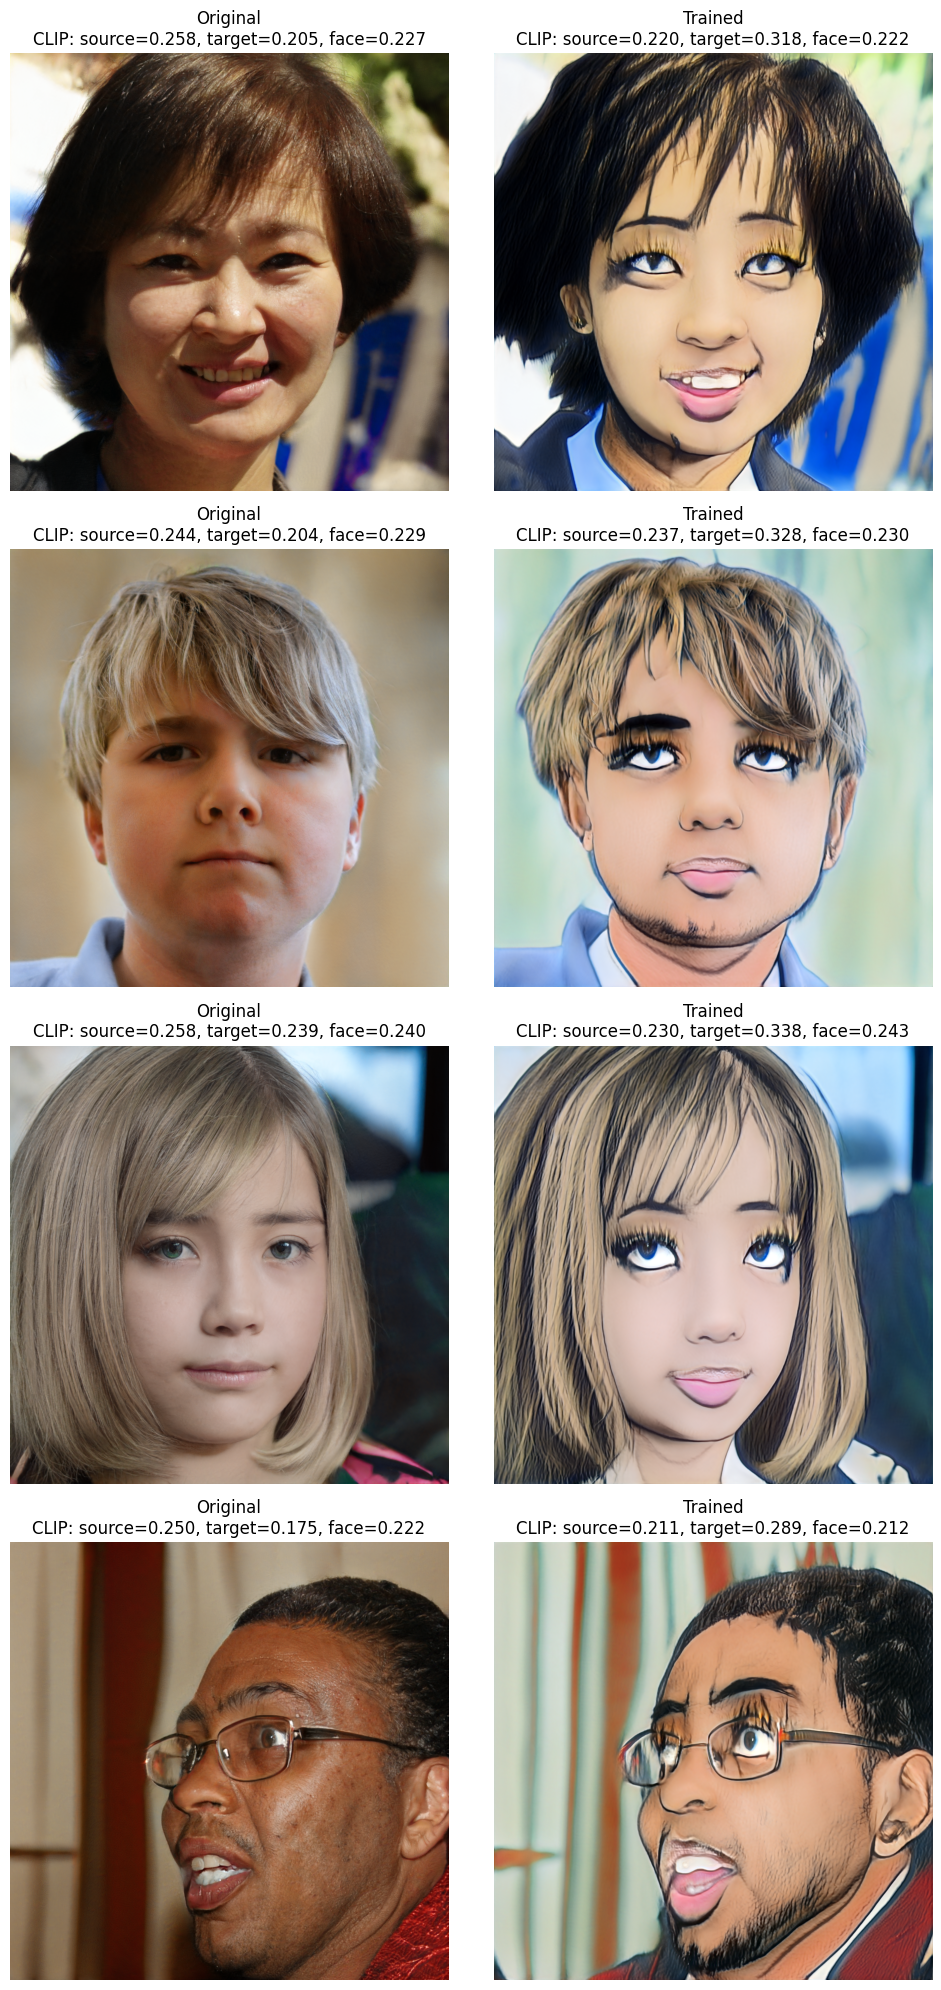

In [30]:
G_frozen.eval()
G_train.eval()
with torch.no_grad():
    z = torch.randn(4, latent_dim, device=device)
    w = G_frozen.style(z)
    imgs_frozen, _ = G_frozen([w], input_is_latent=True)
    imgs_train, _ = G_train([w], input_is_latent=True)

    # Compute CLIP similarities for source, target, and "face" text
    E_t_s = E_t_source / E_t_source.norm(dim=-1, keepdim=True)
    E_t_t = E_t_target / E_t_target.norm(dim=-1, keepdim=True)
    t_face = clip.tokenize(["face"]).to(device)
    E_t_face = clip_model.encode_text(t_face) / clip_model.encode_text(t_face).norm(dim=-1, keepdim=True)

    def clip_sims(imgs, E_s, E_t, E_face):
        img_clip = preprocess_for_clip(imgs)
        enc = clip_model.encode_image(img_clip)
        enc = enc / enc.norm(dim=-1, keepdim=True)
        sim_source = (enc * E_s.expand(enc.shape[0], -1)).sum(dim=-1)
        sim_target = (enc * E_t.expand(enc.shape[0], -1)).sum(dim=-1)
        sim_face = (enc * E_face.expand(enc.shape[0], -1)).sum(dim=-1)
        return sim_source.cpu().numpy(), sim_target.cpu().numpy(), sim_face.cpu().numpy()

    sim_src_frozen, sim_tgt_frozen, sim_face_frozen = clip_sims(imgs_frozen, E_t_s, E_t_t, E_t_face)
    sim_src_train, sim_tgt_train, sim_face_train = clip_sims(imgs_train, E_t_s, E_t_t, E_t_face)

def to_np(tensor):
    x = (tensor.clamp(-1, 1) + 1) / 2
    return x.squeeze(0).permute(1, 2, 0).cpu().numpy()

fig, axes = plt.subplots(4, 2, figsize=(10, 20))
for i in range(4):
    axes[i, 0].imshow(to_np(imgs_frozen[i:i+1]))
    axes[i, 0].axis("off")
    axes[i, 0].set_title(f"Original\nCLIP: source={sim_src_frozen[i]:.3f}, target={sim_tgt_frozen[i]:.3f}, face={sim_face_frozen[i]:.3f}")
    axes[i, 1].imshow(to_np(imgs_train[i:i+1]))
    axes[i, 1].axis("off")
    axes[i, 1].set_title(f"Trained\nCLIP: source={sim_src_train[i]:.3f}, target={sim_tgt_train[i]:.3f}, face={sim_face_train[i]:.3f}")
plt.tight_layout()
plt.show()